Here, the performance of the lookup tables optimized in the "example_F_lookup_training_test.ipynb" on state stabilization for longer time durations can be tested.

In [1]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

from feedback_grape.utils.operators import (
    sigmax,
    sigmay,
    sigmaz,
    sigmap,
    sigmam,
)
from feedback_grape.utils.states import basis
from feedback_grape.fgrape import Gate, Decay
import jax
from jax import numpy as jnp
from library.utils.qubit_chain_1D import embed
from tqdm import tqdm
from jax.scipy.linalg import expm

# Test parameters
N_timesteps = 50 # Number of time steps to test
N_samples = 16 # Number of random initializations to test

# Optimized parameters
lut_file = "best_result_lookup_timesteps=5.json" # File containing optimized parameters
rnn_file = "best_result_rnn_timesteps=5.json" # File containing optimized parameters
figure_file = "lookup_vs_rnn_performance_timesteps=5.png" # File to save the performance figure

# System parameters
n = 5 # Number of qubits
measurement_sites = [0, 3] # Sites where measurements are performed (0-indexed)
flip_sites = [2, 4] # Sites to be flipped (0-indexed)
control_qubit = 0 # Qubit where control rotations are applied (0-indexed)
decay_constant = jnp.sqrt(0.005) # Decay constant for amplitude damping

# Initial and target state with excitation at flip_sites
psi = basis(2**n, 0)
for k in flip_sites:
    psi = embed(sigmax(), k, n) @ psi
rho_excited = psi @ psi.conj().T
rho_excited /= jnp.trace(rho_excited) # Normalize

# Control operators (bloch rotation on control qubit and sigmam, sigmap between neighboring qubits)
def transport_unitary(params):
    return expm(-1j*sum([
        -t*embed(sigmap(), i, n)@embed(sigmam(), i+1, n) - t*embed(sigmam(), i, n)@embed(sigmap(), i+1, n)
        for i,t in enumerate(params)
    ]))

def initialize_transport_gates(key):
    return Gate(
        gate = transport_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(n-1,), # n-1 couplings
            minval=0.0,
            maxval=1.0,
            dtype=float,
        ),
        measurement_flag=False,
    )

def rotation_unitary(params):
    alpha, beta = params
    return expm(-1j*(alpha*embed(sigmax(), control_qubit, n) + beta*embed(sigmay(), control_qubit, n)))

def initialize_rotation_gate(key):
    return Gate(
        gate = rotation_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(2,), # alpha, beta
            minval=-jnp.pi,
            maxval=jnp.pi,
            dtype=float,
        ),
        measurement_flag=False,
    )

# Measurement operator (projective measurement along axis defined by theta, phi)
def povm(measurement_outcome, params, k):
    theta, phi = params
    x,y,z = jnp.sin(theta)*jnp.cos(phi), jnp.sin(theta)*jnp.sin(phi), jnp.cos(theta)

    S = x*sigmax() + y*sigmay() + z*sigmaz()
    P1 = (jnp.eye(2) + S)/2
    P2 = (jnp.eye(2) - S)/2

    return jnp.where(
        measurement_outcome == 1,
        embed(P1, k, n),
        embed(P2, k, n),
    )

def initialize_povm_gates(key):
    povm_gates = []
    for k in measurement_sites:
        povm_gates.append(
            Gate(
                gate = lambda measurement_outcome, params, k=k: povm(measurement_outcome, params, k) + povm(measurement_outcome, params, k),
                initial_params=jax.random.uniform(
                    jax.random.PRNGKey(key+k),
                    shape=(2,), # theta, phi
                    minval=-jnp.pi,
                    maxval=jnp.pi,
                    dtype=float,
                ),
                measurement_flag=True,
            )
        )

    return povm_gates

# Decay operator (amplitude damping on all qubits)
decay_gate = Decay(c_ops=[decay_constant * embed(sigmap(), k, n) for k in range(n)])

# Assert that measurement operator is valid
assert jnp.allclose(povm(-1, (0, 0), 0) + povm(1, (0, 0), 0), jnp.eye(2**n)), "Measurement operators do not sum to identity"

system_params = initialize_povm_gates(key=0) + [initialize_rotation_gate(key=0), decay_gate, initialize_transport_gates(key=0), decay_gate]

In [2]:
from re import sub
import feedback_grape
from feedback_grape.fgrape import FgResult
from feedback_grape.utils.fgrape_helpers import (
    convert_system_params,
    convert_to_index,
)

from pyparsing import C
 # Override this internal function with my modified version to handle lookup tables on longer time durations 
def extract_from_lut(lut, measurement_history):
    """
    Extract parameters from the lookup table based on the measurement history.

    Args:
        lut: Lookup table for parameters.
        measurement_history: History of measurements.

    Returns:
        Extracted parameters.
    """
    sub_array_idx = min(len(measurement_history) - 1, len(lut) - 1) # MODIFIED LINE: Uses the last available sub-array if measurement history is longer than lut
    sub_array_param_idx = convert_to_index(measurement_history) & (2**len(lut) - 1) # MODIFIED LINE. Assumes only 1 measurement per time step
    return jnp.array(lut)[sub_array_idx][sub_array_param_idx]

feedback_grape.fgrape.extract_from_lut = extract_from_lut

def evaluate_on_longer_time(
    U_0: jnp.ndarray,
    C_target: jnp.ndarray,
    system_params: list[Gate],
    optimized_trainable_parameters: list[jnp.ndarray],
    num_time_steps: int,
    evo_type: str,  # state, density (used now mainly for fidelity calculation)
    goal: str,  # purity, fidelity, both
    eval_batch_size: int,
    mode: str,  # nn, lookup
    rnn: callable,  # type: ignore
    rnn_hidden_size: int,
) -> FgResult:

    (
        initial_params,
        parameterized_gates,
        measurement_indices,
        param_constraints,
        c_ops,
        decay_indices,
    ) = convert_system_params(system_params)

    param_shapes = None
    num_of_params = len(jax.tree_util.tree_leaves(initial_params))

    if mode == "no-measurement":
        # If no feedback is used, we can just use the initial parameters
        h_initial_state = None
        rnn_model = None

        if not (measurement_indices == [] or measurement_indices is None):
            raise ValueError(
                "You set a measurement flag to true, but no-measurement mode is used. Please set mode to 'nn' or 'lookup'."
            )
    else:
        if measurement_indices == [] or measurement_indices is None:
            raise ValueError(
                "For modes 'nn' and 'lookup', you must provide at least one measurement operator in your system_params. "
            )
        # Convert dictionary parameters to list[list] structure
        flat_params, param_shapes = feedback_grape.utils.fgrape_helpers.prepare_parameters_from_dict(initial_params)

        # Calculate total number of parameters
        if mode == "nn":
            hidden_size = rnn_hidden_size
            output_size = num_of_params
            rnn_model = rnn(hidden_size=hidden_size, output_size=output_size)  # type: ignore

            h_initial_state = jnp.zeros((1, hidden_size))
            dummy_input = jnp.zeros(
                (1, 1)
            )  # Dummy input for rnn initialization

            rnn_model.init(
                jax.random.PRNGKey(0), dummy_input, h_initial_state
            )  # Initialize RNN parameters

        elif mode == "lookup":
            h_initial_state = None
            rnn_model = None
        else:
            raise ValueError(
                "Invalid mode. Choose 'nn' or 'lookup' or 'no-measurement'."
            )

    result = feedback_grape.fgrape._evaluate(
        U_0=U_0,
        C_target=C_target,
        parameterized_gates=parameterized_gates,
        measurement_indices=measurement_indices,
        param_constraints=param_constraints,
        c_ops=c_ops,
        decay_indices=decay_indices,
        param_shapes=param_shapes,
        best_model_params=optimized_trainable_parameters,
        mode=mode,
        num_time_steps=num_time_steps,
        evo_type=evo_type,
        eval_batch_size=eval_batch_size,
        prng_key=jax.random.PRNGKey(42),
        h_initial_state=h_initial_state,
        rnn_model=rnn_model,
        goal=goal,
        num_iterations=0, # No optimization, just evaluation
    )

    return result

In [3]:
# open test table from json file
import json, matplotlib.pyplot as plt

with open(lut_file, "r") as f:
    test_table = json.load(f)

fidelities_lut = []
for t in jnp.arange(1, N_timesteps):
    
    result = evaluate_on_longer_time(
        U_0 = rho_excited,
        C_target = rho_excited,
        system_params = system_params,
        optimized_trainable_parameters = test_table["optimized_trainable_parameters"],
        num_time_steps = t,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = N_samples,
        mode = "lookup",
        rnn = None,
        rnn_hidden_size = 30,
    )

    print(f"Mean Fidelity at timestep {t}: {result.final_fidelity}")
    fidelities_lut.append(result.final_fidelity)

Mean Fidelity at timestep 1: 1.2406662268117467e-09
Mean Fidelity at timestep 2: 1.4258989329516972e-09
Mean Fidelity at timestep 3: 8.055288163488979e-10
Mean Fidelity at timestep 4: 4.62464456835862e-10
Mean Fidelity at timestep 5: 0.9424013296195656
Mean Fidelity at timestep 6: 0.11711740867145039
Mean Fidelity at timestep 7: 0.12356117402196892
Mean Fidelity at timestep 8: 0.13441869761653225
Mean Fidelity at timestep 9: 0.13960035152124883
Mean Fidelity at timestep 10: 0.26825335525129307
Mean Fidelity at timestep 11: 0.0436517811216507
Mean Fidelity at timestep 12: 0.01582867091110721
Mean Fidelity at timestep 13: 0.015185715778856497
Mean Fidelity at timestep 14: 0.02241099102639183
Mean Fidelity at timestep 15: 0.025419657582800393
Mean Fidelity at timestep 16: 0.022609259849461737
Mean Fidelity at timestep 17: 0.021390115216324578
Mean Fidelity at timestep 18: 0.022346392808950233
Mean Fidelity at timestep 19: 0.023884477505867474
Mean Fidelity at timestep 20: 0.02371511332005

In [4]:
# open test rnn from json file
import json, matplotlib.pyplot as plt
from feedback_grape.fgrape import _DEFAULTS

# VERY IMPORTANT: Go through the RNN parameters and convert lists to jnp arrays
def convert_lists_to_jnp(obj):
    if isinstance(obj, dict):
        return {k: convert_lists_to_jnp(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        try:
            return jnp.array(obj, dtype=jnp.float32)
        except Exception as e:
            for i, item in enumerate(obj):
                obj[i] = convert_lists_to_jnp(item)
            return obj
    else:
        return obj

with open(rnn_file, "r") as f:
    test_rnn = json.load(f)
    test_rnn["optimized_trainable_parameters"] = convert_lists_to_jnp(test_rnn["optimized_trainable_parameters"])

fidelities_rnn = []
for t in jnp.arange(1, N_timesteps):
    
    result = evaluate_on_longer_time(
        U_0 = rho_excited,
        C_target = rho_excited,
        system_params = system_params,
        optimized_trainable_parameters = test_rnn["optimized_trainable_parameters"],
        num_time_steps = t,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = N_samples,
        mode = "nn",
        rnn = _DEFAULTS.RNN.value, # Use default RNN
        rnn_hidden_size = 30,
    )

    print(f"Mean Fidelity at timestep {t}: {result.final_fidelity}")
    fidelities_rnn.append(result.final_fidelity)

Mean Fidelity at timestep 1: 3.0029410484990264e-10
Mean Fidelity at timestep 2: 3.739554522097268e-09
Mean Fidelity at timestep 3: 3.803307118652197e-13
Mean Fidelity at timestep 4: 2.965929942218919e-11
Mean Fidelity at timestep 5: 0.9801742386859381
Mean Fidelity at timestep 6: 0.0023403357583818498
Mean Fidelity at timestep 7: 0.018296955730421005
Mean Fidelity at timestep 8: 0.08623078869309447
Mean Fidelity at timestep 9: 0.05770961456230003
Mean Fidelity at timestep 10: 0.010100050436695216
Mean Fidelity at timestep 11: 0.010471345643972584
Mean Fidelity at timestep 12: 0.004788888939190896
Mean Fidelity at timestep 13: 0.014250399074780054
Mean Fidelity at timestep 14: 0.19725429113558468
Mean Fidelity at timestep 15: 0.008203544754104963
Mean Fidelity at timestep 16: 0.04818586372954882
Mean Fidelity at timestep 17: 0.06505728950276178
Mean Fidelity at timestep 18: 0.031203715731526173
Mean Fidelity at timestep 19: 0.0053332023097289885
Mean Fidelity at timestep 20: 0.01032881

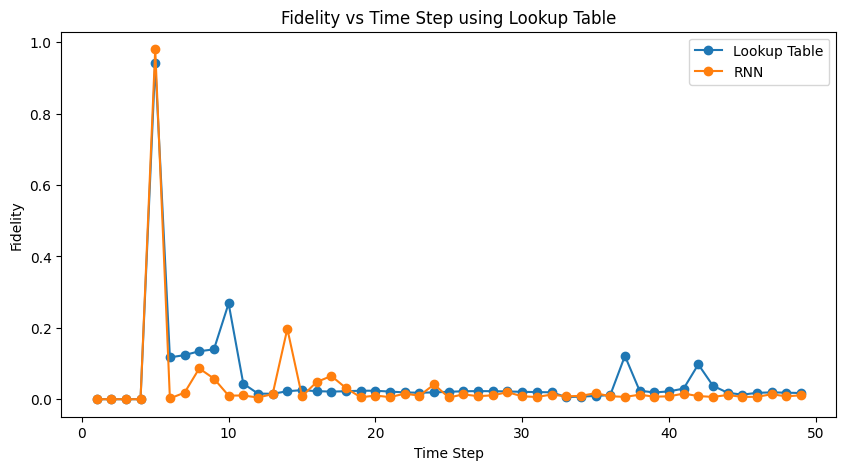

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(jnp.arange(1, N_timesteps), fidelities_lut, marker='o', label='Lookup Table')
ax.plot(jnp.arange(1, N_timesteps), fidelities_rnn, marker='o', label='RNN')
ax.set_xlabel('Time Step')
ax.set_ylabel('Fidelity')
ax.set_title('Fidelity vs Time Step using Lookup Table')

ax.legend()
fig.savefig(figure_file, dpi=300)

In [6]:
# Play a sound when done
import os
os.system('say "fertig"')

0